Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt


Constants

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANELS=3
EPOCHS=20

Data Preprocessing

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "mango_dataset",

    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    shuffle=True,
   
)
   

Found 4000 files belonging to 8 classes.


In [5]:
class_names= dataset.class_names
class_names

['Anthracnose',
 'Bacterial Canker',
 'Cutting Weevil',
 'Die Back',
 'Gall Midge',
 'Healthy',
 'Powdery Mildew',
 'Sooty Mould']

In [6]:
len(dataset)

125

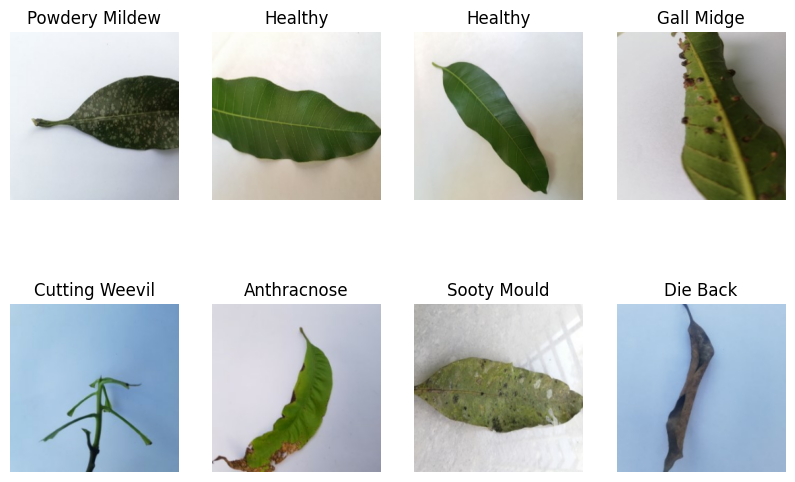

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [8]:
len(dataset)

125

In [9]:
# 80% ==> training 
# 20% ==> validaton,10% test

In [10]:
train_size=0.8
len(dataset)*train_size

100.0

In [11]:
train_ds=dataset.take(100)
len(train_ds)

100

In [12]:
test_ds=dataset.skip(100)
len(test_ds)

25

In [13]:
val_size=0.1
len(dataset)*val_size

12.5

In [14]:
val_ds=test_ds.take(12)
len(val_ds)

12

function t split dataset into train,validation and test


In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)


100

In [18]:
len(val_ds)


12

In [19]:

len(test_ds)

13

Catch shuffle and prefetch the datset

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [21]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])


In [22]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])


In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Building


In [24]:


# Adjusting number of classes to 8
n_classes = 8

# Input shape for your images
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANELS)

# Defining the model
model = models.Sequential([
    resize_and_rescale,  # Ensure this is defined correctly for image preprocessing
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),  # Changed to 8 classes
])

# Build the model
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANELS))


c:\Users\Raghunandan\anaconda3\envs\tensorflow_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,072 (719.03 KB)

 Trainable params: 184,072 (719.03 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

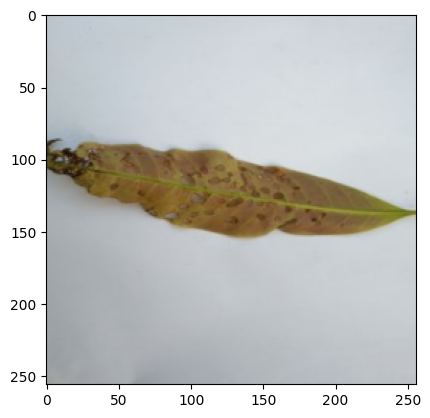

In [27]:
for images_batch,labels_batch in test_ds.take(1):
    plt.imshow(images_batch[0].numpy().astype('uint8'))

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # Stop if validation loss stops improving
    patience=5,           # Wait for 5 epochs before stopping
    restore_best_weights=True  # Restore the best weights when stopping
)

# Train the Model
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=13,  # Set a high epoch count, EarlyStopping will stop it early if needed
    callbacks=[early_stopping]  # Add the callback here
)


Epoch 1/13
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 332ms/step - accuracy: 0.1804 - loss: 1.9680 - val_accuracy: 0.2500 - val_loss: 1.7065
Epoch 2/13
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 328ms/step - accuracy: 0.3620 - loss: 1.4659 - val_accuracy: 0.5130 - val_loss: 1.1936
Epoch 3/13
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 342ms/step - accuracy: 0.6040 - loss: 1.0332 - val_accuracy: 0.7318 - val_loss: 0.7596
Epoch 4/13
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 351ms/step - accuracy: 0.7293 - loss: 0.7430 - val_accuracy: 0.6771 - val_loss: 0.7565
Epoch 5/13
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 352ms/step - accuracy: 0.7536 - loss: 0.6521 - val_accuracy: 0.8750 - val_loss: 0.3592
Epoch 6/13
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 352ms/step - accuracy: 0.8433 - loss: 0.4214 - val_accuracy: 0.8125 - val_loss: 0.4542
Epoch 7/13
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 357ms/step - accuracy: 0.8265 - loss: 0.4530 - val_accuracy: 0.8646 - val_loss: 0.3309
Epoch 8/13
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 357ms/step - accuracy: 0.8765 - loss: 0

In [29]:
scores=model.evaluate(test_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9418 - loss: 0.1640


In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


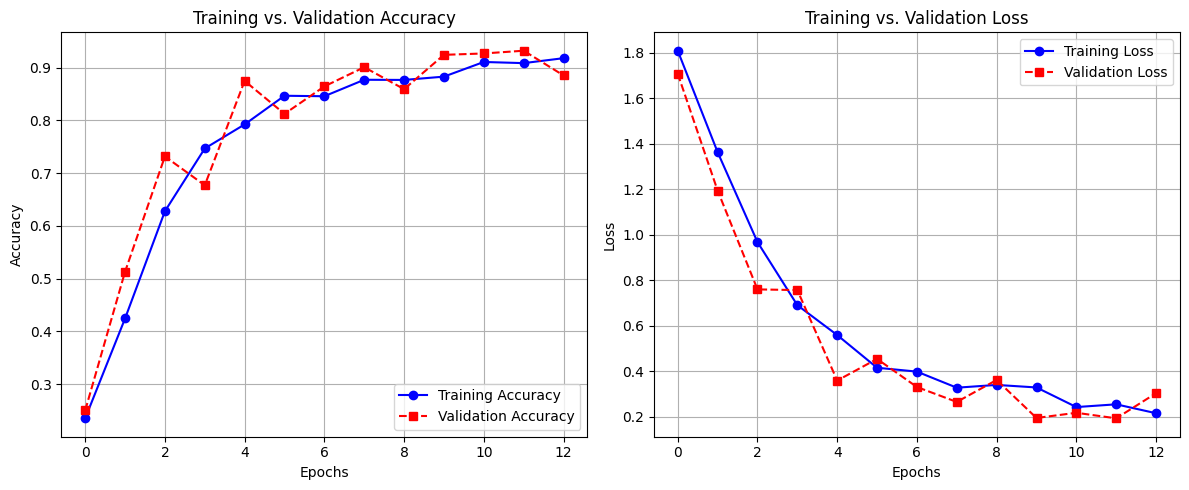

In [31]:


# Ensure the number of epochs is dynamic
epochs = len(acc)

plt.figure(figsize=(12, 5))  # Increased figure size for better visibility

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, marker='o', linestyle='-', label='Training Accuracy', color='blue')
plt.plot(range(epochs), val_acc, marker='s', linestyle='--', label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)  # Add grid for better readability

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, marker='o', linestyle='-', label='Training Loss', color='blue')
plt.plot(range(epochs), val_loss, marker='s', linestyle='--', label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


first image to predict
actual label: Cutting Weevil
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
predicted label: Cutting Weevil


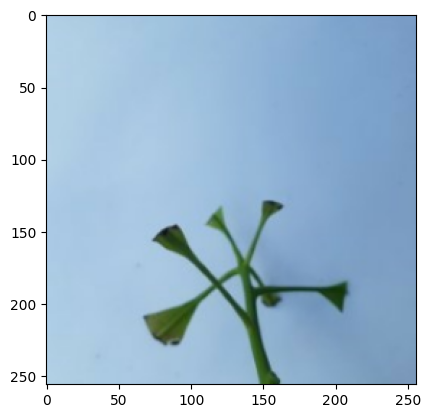

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


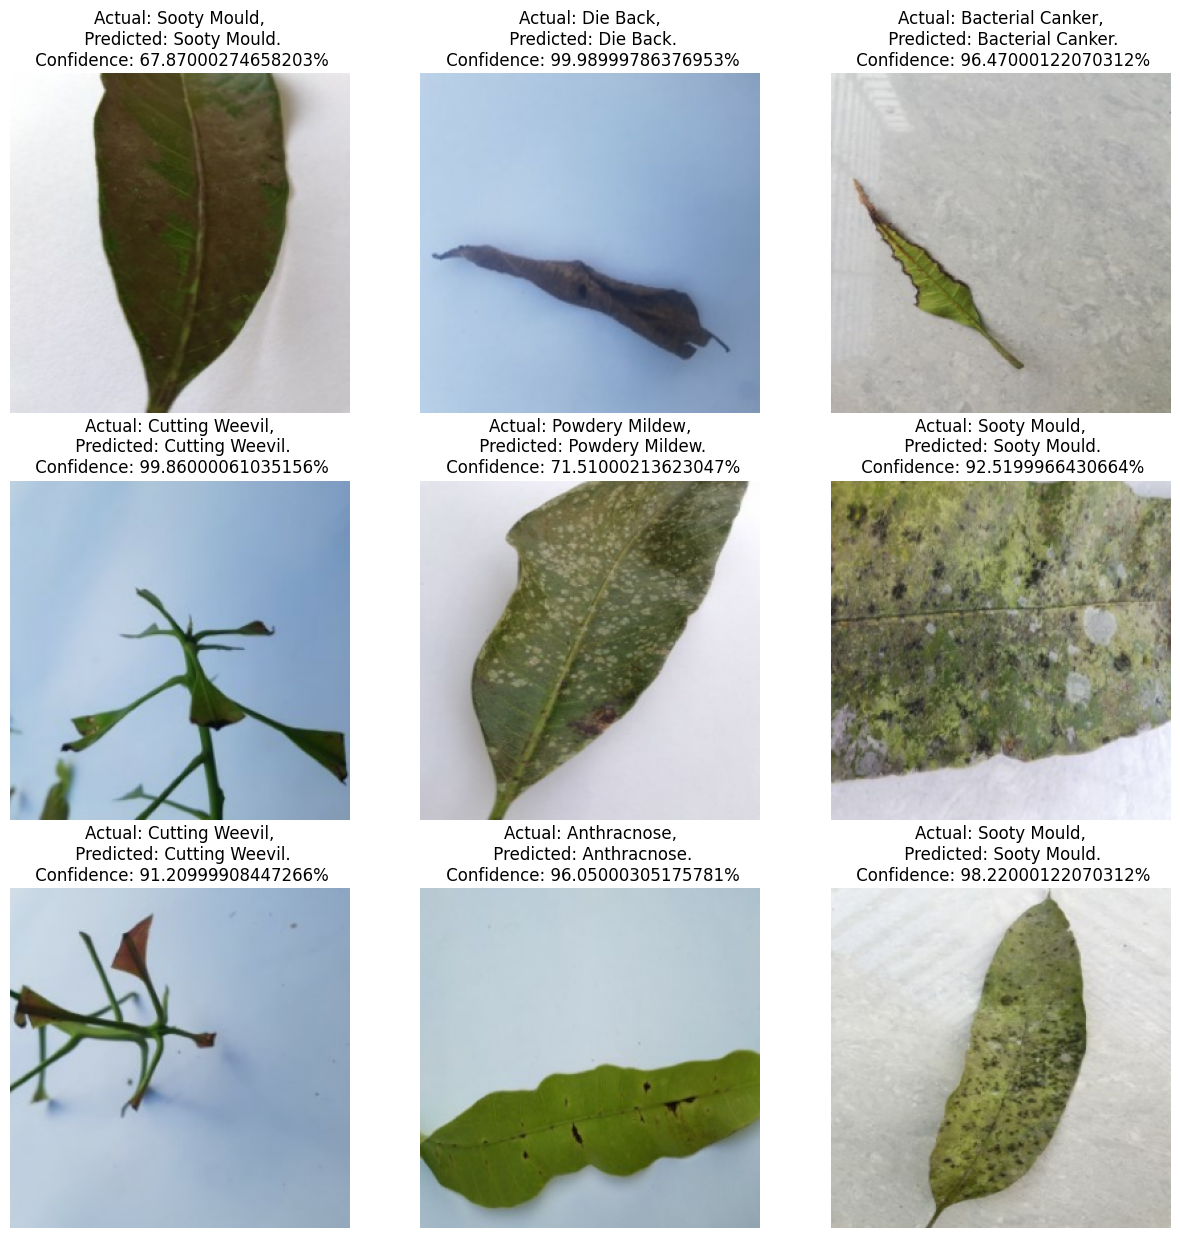

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

saved model into tensorflow format


In [35]:
model_version = 3
model.export(f"../models/{model_version}")


INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets


Saved artifact at '../models/3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_3')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  2296574126112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296574131568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296574130512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296574946544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296574950240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296574947424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296574939328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296574949888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296574941616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296574939680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296574942320: TensorSpec(shape=(), d

In [36]:
model.save("model.keras")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


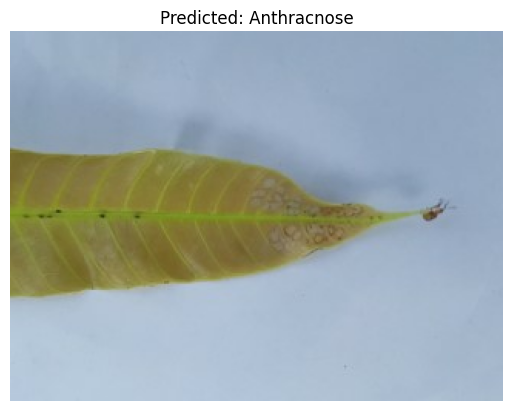


🔹 Class Probabilities:
Anthracnose: 0.9996
Bacterial Canker: 0.0000
Cutting Weevil: 0.0000
Die Back: 0.0000
Gall Midge: 0.0003
Healthy: 0.0000
Powdery Mildew: 0.0001
Sooty Mould: 0.0000

✅ Predicted Class: Anthracnose


In [38]:
#RIGHT CODE
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define image size (Make sure this matches your training input size)
IMAGE_SIZE = 224  # Change this if your model uses a different size

# Class names (Make sure this is in the same order as your training data)
class_names = [
    "Anthracnose", "Bacterial Canker", "Cutting Weevil", "Die Back",
    "Gall Midge", "Healthy", "Powdery Mildew", "Sooty Mould"
]

def load_and_preprocess_image(image_path):
    """Loads an image and applies the same preprocessing as training."""
    img = tf.io.read_file(image_path)  # Read the image file
    img = tf.image.decode_jpeg(img, channels=3)  # Decode as RGB
    #img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to match model input
    #img = img / 255.0  # Normalize pixel values (0 to 1)
    
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Load the trained model (Make sure this path is correct)
model = tf.keras.models.load_model(r"C:\Users\Raghunandan\OneDrive\Desktop\project\plant_disease_project\training\model.keras")  # Load saved model version 3

# Image path (Change this to your test image)
image_path = r"C:\Users\Raghunandan\OneDrive\Desktop\project\plant_disease_project\training\mango_dataset\Anthracnose\20211008_124249 (Custom).jpg"
# Preprocess and predict
processed_image = load_and_preprocess_image(image_path)
prediction = model.predict(processed_image)

# Get predicted class
predicted_class_index = np.argmax(prediction[0])
predicted_class = class_names[predicted_class_index]

# Display image and prediction
plt.imshow(tf.squeeze(processed_image))  # Remove batch dimension for display
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()

# Print class probabilities
print("\n🔹 Class Probabilities:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {prediction[0][i]:.4f}")

print(f"\n✅ Predicted Class: {predicted_class}")
